In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

In [2]:
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [3]:
# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Conexión a BD
# ==============================================================================
import pyodbc

In [8]:
# Configuración de BD y conexión
# ==============================================================================
direccion_servidor = '192.168.1.32,55078'
nombre_bd = 'BDVirunet'
nombre_usuario = 'sa'
password = '123456'
try:
    conexion = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + 
                              direccion_servidor+';DATABASE='+nombre_bd+';UID='+nombre_usuario+';PWD=' + password)
    print("Conexión exitosa")
    
except Exception as e:
    print("Ocurrió un error al conectar a SQL Server: ", e)

Conexión exitosa


# Recolección de datos

Evaluamos la fenología de Floración

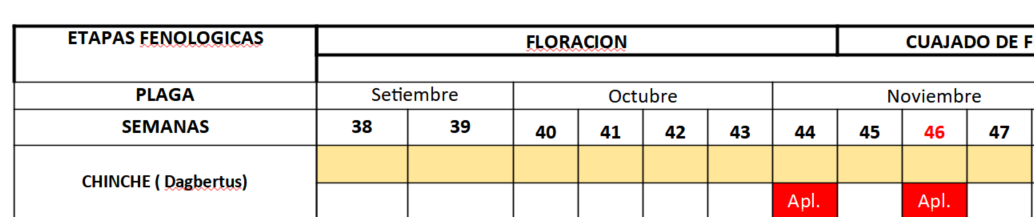

## Plagas

In [9]:
dFechaInicio = '2019-01-01'
dFechaFin = '2019-12-31'

In [10]:
try:
    with conexion.cursor() as cursor:
            consulta = "exec STP_OBTENER_TOTALIZADO_PLAGAS ?,?,?,?"
            cursor.execute(consulta, (dFechaInicio, dFechaFin, 1,0))

            rows = cursor.fetchall()
            
            cols = []
            
            for i,_ in enumerate(cursor.description):
                cols.append(cursor.description[i][0])

            pd.DataFrame(np.array(rows), columns = cols)
            
            df = pd.DataFrame(columns =['Evaluador','Fecha','Fundo','Filtrado','Turno','Lote','Grupo_Plaga','Plaga','Caracteristica','Suma','Grado','Promedio','Porcentaje'] )
            for i in range(len(rows)):
                df.loc[i] = list(rows[i])
except Exception as e: 
    print(e)

Filtramos el filtrado 30

In [11]:
dfF30 = df

In [12]:
dfF30 = dfF30[dfF30["Plaga"] == "DAGBERTUS MINENSIS, DAGBERTUS PERUANUS"]

In [13]:
for filtrado in df["Filtrado"].unique():
    print("Filtrado: " + filtrado)
    nCantidadFiltrado = df[df["Filtrado"] == filtrado].shape[0]
    print("Cantidad: " + str(nCantidadFiltrado))
    print("**************************")

Filtrado: 10N
Cantidad: 2286
**************************
Filtrado: 11N
Cantidad: 3009
**************************
Filtrado: 13
Cantidad: 2599
**************************
Filtrado: 15
Cantidad: 575
**************************
Filtrado: 16
Cantidad: 615
**************************
Filtrado: 17
Cantidad: 1487
**************************
Filtrado: 18
Cantidad: 419
**************************
Filtrado: 20
Cantidad: 1360
**************************
Filtrado: 22
Cantidad: 739
**************************
Filtrado: 29
Cantidad: 4239
**************************
Filtrado: 30
Cantidad: 4050
**************************
Filtrado: 9N
Cantidad: 59
**************************


In [11]:
dfF30 = dfF30.sort_values(by=['Fecha'])

In [12]:
dfF30 = dfF30[['Fecha','Fundo','Filtrado','Turno','Lote','Plaga','Caracteristica','Suma','Porcentaje']]
dfF30[["Suma"]] = dfF30[["Suma"]].apply(pd.to_numeric)
dfF30[["Porcentaje"]] = dfF30[["Porcentaje"]].apply(pd.to_numeric)

In [13]:
dfF30 = dfF30.drop_duplicates()

In [14]:
dfF30.reset_index(drop = True, inplace = True)

In [15]:
dfF30.head()

,Fecha,Fundo,Filtrado,Turno,Lote,Plaga,Caracteristica,Suma,Porcentaje
0,2019-06-25,VIRU - PALTO,13,F13,1304,"DAGBERTUS MINENSIS, DAGBERTUS PERUANUS",N° INFLORESC. INFESTADAS,2.0,8
1,2019-06-26,VIRU - PALTO,13,F13,1315,"DAGBERTUS MINENSIS, DAGBERTUS PERUANUS",N° INFLORESC. INFESTADAS,1.0,4
2,2019-07-04,VIRU - PALTO,13,F13,1321,"DAGBERTUS MINENSIS, DAGBERTUS PERUANUS",N° INFLORESC. INFESTADAS,2.0,8
3,2019-07-04,VIRU - PALTO,13,F13,1314,"DAGBERTUS MINENSIS, DAGBERTUS PERUANUS",N° INFLORESC. INFESTADAS,3.0,12
4,2019-07-04,VIRU - PALTO,13,F13,1322,"DAGBERTUS MINENSIS, DAGBERTUS PERUANUS",N° INFLORESC. INFESTADAS,3.0,12


## Clima

In [16]:
data_weather = pd.ExcelFile('C:/Users/Documentos/Documents/Laptop/Bibliografia de tesis/Datos/Datos Climaticos Viru Palto.xlsx')
df_weather = data_weather.parse('TABLA')  
data_weather.close()

In [17]:
df_weather = df_weather[df_weather['Año'] == 2019]
df_weather = df_weather[(df_weather['Fecha'] >= dFechaInicio) & (df_weather['Fecha'] <= dFechaFin)]
df_weather.reset_index(drop = True, inplace = True)

In [18]:
df_weather = df_weather[['Fecha','ET(mm).','Tº MIN/DIA (°C)','Tº MAX/DIA (°C)','Rad. Solar Prom.','HUMEDAD PROM.', 'T° Prom/Día (°C)','Semana']]
df_weather = df_weather.rename(columns = {'ET(mm).' : 'ET', 
                                      'Tº MIN/DIA (°C)' : 'T_MIN',
                                     'Tº MAX/DIA (°C)': 'T_MAX',
                                     'Rad. Solar Prom.' : 'RS_PROM',
                                     'HUMEDAD PROM.': 'HM_PROM',
                                      'T° Prom/Día (°C)': 'TMP_PROM',
                                         'Semana': 'Semana'})

###  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS

In [19]:
arrFiltrados = dfF30['Filtrado'].unique()

In [20]:
arrFiltrados

array(['13', '29', '16', '10N', '11N', '30'], dtype=object)

------------------------------------------------------------
Lugar: Filtrado 13 - Turno F13 - Lote 1304
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
------------------------------------------------------------
        Fecha  Semana     ET   TMP_PROM  RS_PROM  HM_PROM  T_MIN  T_MAX  \
0  2019-06-25      26  2.400  18.539583    220.9     87.0   17.1   22.5   
1  2019-07-09      28  1.300  17.402083     88.9     91.0   16.3   21.8   
2  2019-07-18      29  0.400  16.302083     30.5     90.0   15.8   17.1   
3  2019-08-28      35  0.700  16.739583     49.2     88.0   15.5   18.8   
4  2019-11-04      45  2.400  18.410417    154.0     82.0   16.7   22.1   
5  2019-11-12      46  2.200  19.502083    135.0     85.0   17.9   22.7   
6  2019-11-19      47  1.372  19.016667     83.0     82.0   17.7   21.8   

   Porcentaje  
0           8  
1          24  
2          16  
3           8  
4           4  
5           8  
6           8  


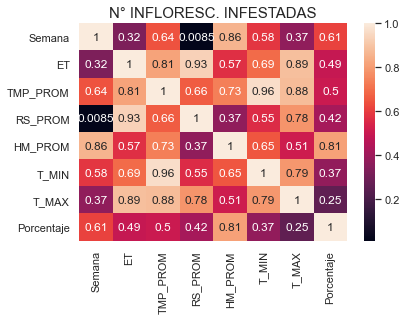

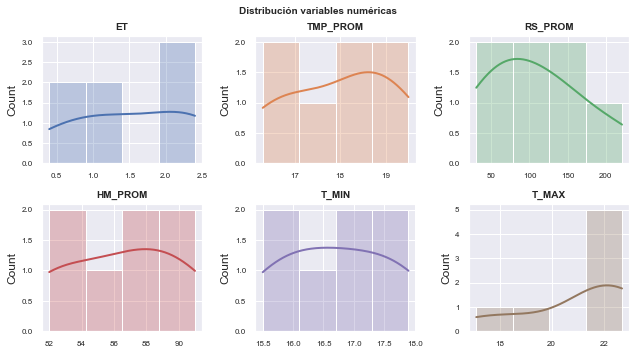

------------------------------------------------------------
Lugar: Filtrado 13 - Turno F13 - Lote 1315
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
------------------------------------------------------------
        Fecha  Semana     ET   TMP_PROM  RS_PROM  HM_PROM  T_MIN  T_MAX  \
0  2019-06-26      26  2.100  17.968852    254.3     89.0   15.0   22.3   
1  2019-07-09      28  1.300  17.402083     88.9     91.0   16.3   21.8   
2  2019-07-18      29  0.400  16.302083     30.5     90.0   15.8   17.1   
3  2019-10-30      44  3.500  18.831250    226.1     85.0   15.3   23.5   
4  2019-11-06      45  3.200  18.652083    209.1     85.0   16.2   23.2   
5  2019-11-12      46  2.200  19.502083    135.0     85.0   17.9   22.7   
6  2019-11-20      47  3.124  19.381250    202.6     87.0   16.8   21.2   

   Porcentaje  
0           4  
1          16  
2          20  
3           4  
4          12  
5          16  
6           4  


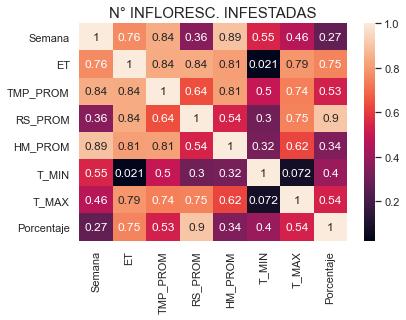

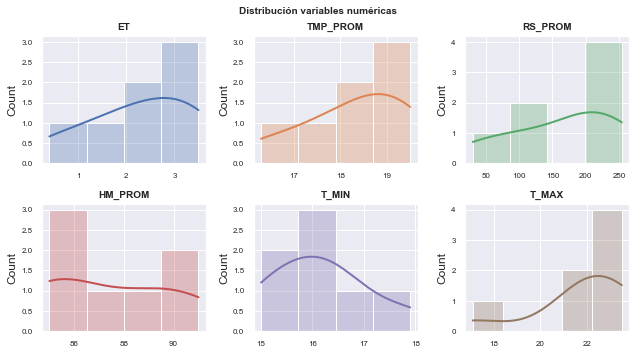

------------------------------------------------------------
Lugar: Filtrado 13 - Turno F13 - Lote 1305
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
------------------------------------------------------------
        Fecha  Semana     ET   TMP_PROM  RS_PROM  HM_PROM  T_MIN  T_MAX  \
0  2019-07-05      27  2.500  18.516667    170.6     87.0   15.9   24.4   
1  2019-07-09      28  1.300  17.402083     88.9     91.0   16.3   21.8   
2  2019-07-18      29  0.400  16.302083     30.5     90.0   15.8   17.1   
3  2019-08-22      34  2.600  16.600000    178.1     86.0   15.0   22.1   
4  2019-10-29      44  1.800  17.879167    109.9     83.0   15.8   21.9   
5  2019-11-12      46  2.200  19.502083    135.0     85.0   17.9   22.7   
6  2019-11-19      47  1.372  19.016667     83.0     82.0   17.7   21.8   

   Porcentaje  
0           4  
1          20  
2          28  
3           8  
4           8  
5          16  
6           8  


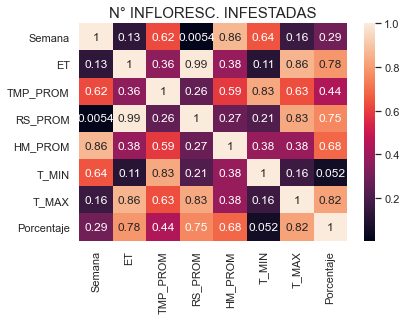

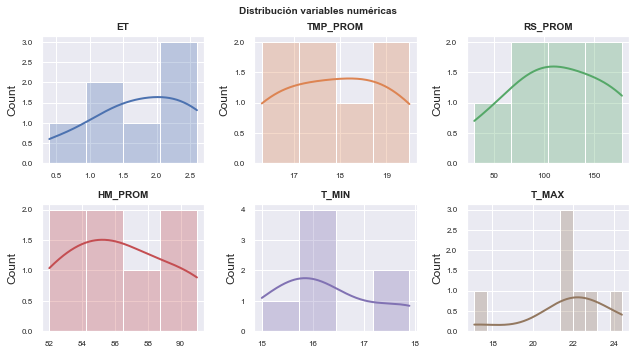

------------------------------------------------------------
Lugar: Filtrado 13 - Turno F13 - Lote 1320
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
------------------------------------------------------------
        Fecha  Semana     ET   TMP_PROM  RS_PROM  HM_PROM  T_MIN  T_MAX  \
0  2019-07-05      27  2.500  18.516667    170.6     87.0   15.9   24.4   
1  2019-07-10      28  2.400  17.433333    160.6     92.0   16.2   23.4   
2  2019-07-18      29  0.400  16.302083     30.5     90.0   15.8   17.1   
3  2019-08-23      34  1.500  15.831250    105.0     88.0   15.2   20.3   
4  2019-10-28      44  3.900  18.514583    248.7     85.0   15.1   23.1   
5  2019-11-06      45  3.200  18.652083    209.1     85.0   16.2   23.2   
6  2019-11-12      46  2.200  19.502083    135.0     85.0   17.9   22.7   
7  2019-11-20      47  3.124  19.381250    202.6     87.0   16.8   21.2   

   Porcentaje  
0          20  
1          28  
2          28  
3     

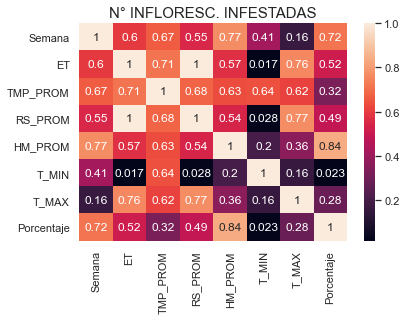

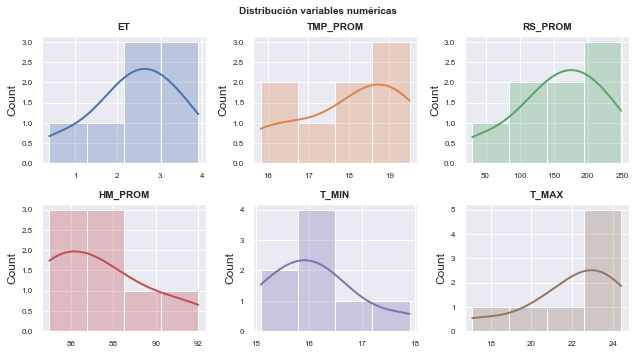

------------------------------------------------------------
Lugar: Filtrado 13 - Turno F13 - Lote 1316
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
------------------------------------------------------------
        Fecha  Semana     ET   TMP_PROM  RS_PROM  HM_PROM  T_MIN  T_MAX  \
0  2019-07-05      27  2.500  18.516667    170.6     87.0   15.9   24.4   
1  2019-07-10      28  2.400  17.433333    160.6     92.0   16.2   23.4   
2  2019-07-20      29  2.800  16.564583    194.9     90.0   11.4   22.3   
3  2019-08-23      34  1.500  15.831250    105.0     88.0   15.2   20.3   
4  2019-11-06      45  3.200  18.652083    209.1     85.0   16.2   23.2   
5  2019-11-12      46  2.200  19.502083    135.0     85.0   17.9   22.7   
6  2019-11-20      47  3.124  19.381250    202.6     87.0   16.8   21.2   

   Porcentaje  
0           8  
1          12  
2          20  
3          12  
4          12  
5          12  
6           8  


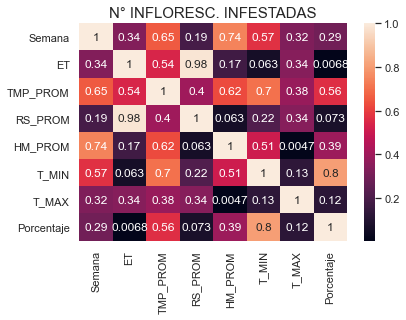

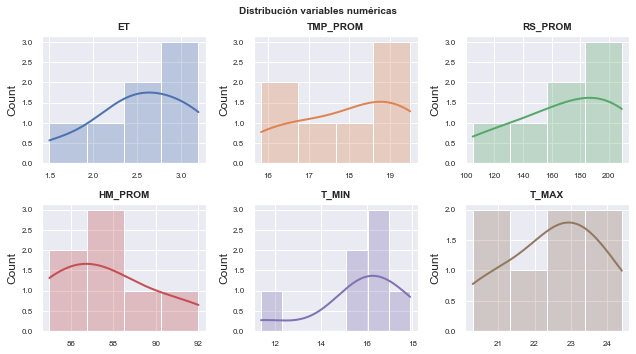

------------------------------------------------------------
Lugar: Filtrado 13 - Turno F13 - Lote 1310
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
------------------------------------------------------------
        Fecha  Semana     ET   TMP_PROM  RS_PROM  HM_PROM  T_MIN  T_MAX  \
0  2019-07-05      27  2.500  18.516667    170.6     87.0   15.9   24.4   
1  2019-07-10      28  2.400  17.433333    160.6     92.0   16.2   23.4   
2  2019-07-19      29  1.000  16.437500     70.3     90.0   13.5   20.9   
3  2019-08-15      33  2.400  17.845833    166.6     89.0   16.1   22.3   
4  2019-09-11      37  3.100  16.856250    203.4     90.0   13.1   22.0   
5  2019-10-24      43  3.800  17.622917    251.0     84.0   13.3   22.9   
6  2019-10-30      44  3.500  18.831250    226.1     85.0   15.3   23.5   
7  2019-11-06      45  3.200  18.652083    209.1     85.0   16.2   23.2   
8  2019-11-12      46  2.200  19.502083    135.0     85.0   17.9   22.7

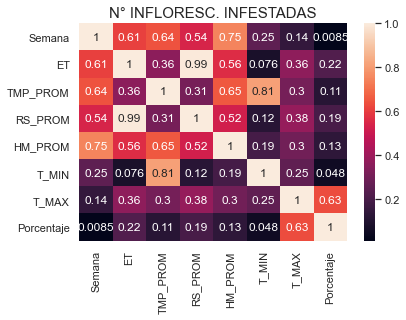

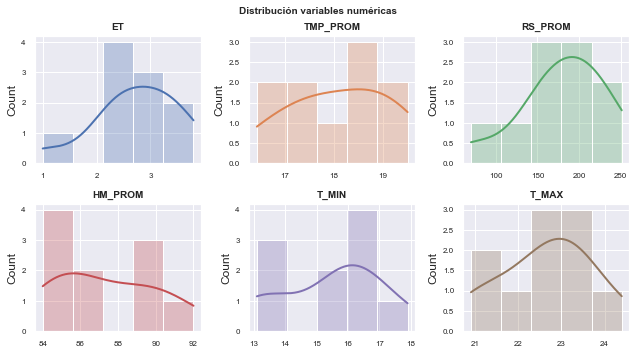

------------------------------------------------------------
Lugar: Filtrado 13 - Turno F13 - Lote 1308
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
------------------------------------------------------------
        Fecha  Semana     ET   TMP_PROM  RS_PROM  HM_PROM  T_MIN  T_MAX  \
0  2019-07-06      27  2.000  17.893750    137.9     86.0   15.6   21.8   
1  2019-07-09      28  1.300  17.402083     88.9     91.0   16.3   21.8   
2  2019-07-18      29  0.400  16.302083     30.5     90.0   15.8   17.1   
3  2019-08-14      33  1.300  14.429167     98.7     89.0   14.8   21.6   
4  2019-10-29      44  1.800  17.879167    109.9     83.0   15.8   21.9   
5  2019-11-04      45  2.400  18.410417    154.0     82.0   16.7   22.1   
6  2019-11-12      46  2.200  19.502083    135.0     85.0   17.9   22.7   
7  2019-11-19      47  1.372  19.016667     83.0     82.0   17.7   21.8   

   Porcentaje  
0          12  
1          32  
2          28  
3     

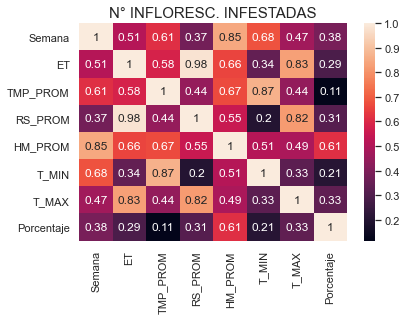

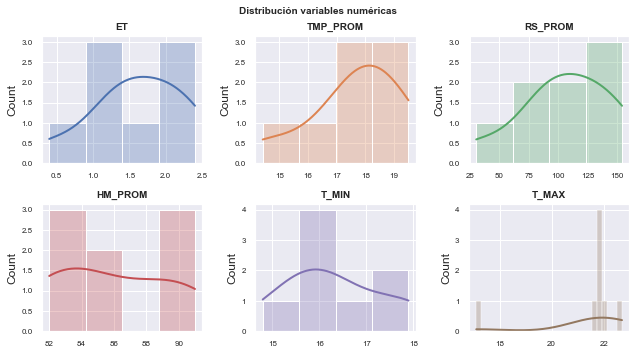

------------------------------------------------------------
Lugar: Filtrado 13 - Turno F13 - Lote 1311
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
------------------------------------------------------------
        Fecha  Semana     ET   TMP_PROM  RS_PROM  HM_PROM  T_MIN  T_MAX  \
0  2019-07-10      28  2.400  17.433333    160.6     92.0   16.2   23.4   
1  2019-07-19      29  1.000  16.437500     70.3     90.0   13.5   20.9   
2  2019-08-15      33  2.400  17.845833    166.6     89.0   16.1   22.3   
3  2019-08-23      34  1.500  15.831250    105.0     88.0   15.2   20.3   
4  2019-11-06      45  3.200  18.652083    209.1     85.0   16.2   23.2   
5  2019-11-12      46  2.200  19.502083    135.0     85.0   17.9   22.7   
6  2019-11-20      47  3.124  19.381250    202.6     87.0   16.8   21.2   

   Porcentaje  
0           4  
1           8  
2           8  
3           4  
4           8  
5          20  
6          24  


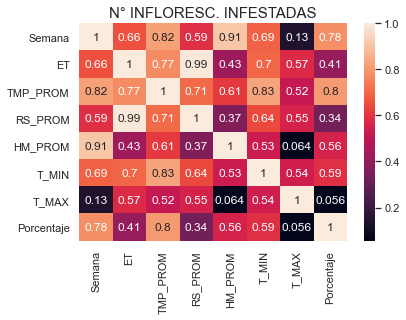

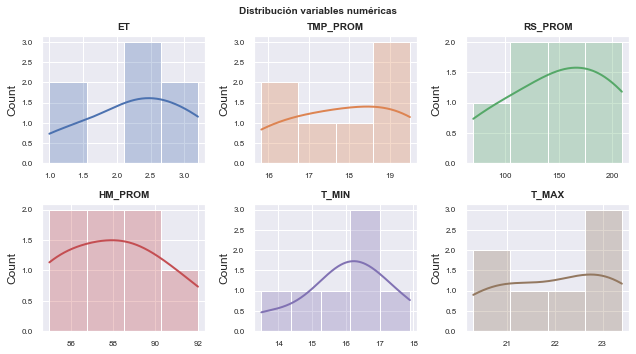

In [21]:
arrPlagas = []
dfFilter = dfF30

#dfFilter = df
dfCorrexLote = pd.DataFrame(columns=['Filtrado', 'Turno', 'Lote', 'Plaga','Caracteristica'])
iContador = 0
for filtrado in arrFiltrados:
    dfFiltrado = dfFilter[dfFilter['Filtrado'] == filtrado]
    arrTurno = dfFiltrado['Turno'].unique()
    for turno in arrTurno:
        dfTurno = dfFiltrado[dfFiltrado['Turno'] == turno]
        arrLote = dfTurno['Lote'].unique()     
        for lote in arrLote:  
            dfLote = dfTurno[dfTurno['Lote'] == lote]
            arrPlagaxLote = dfLote['Plaga'].unique()
            for plaga in arrPlagaxLote:
                dfPlaga = dfLote[dfLote['Plaga'] == plaga]
                arrPlagaxCarac = dfPlaga['Caracteristica'].unique()
                for caracteristica in arrPlagaxCarac:
                    dfCarac = dfPlaga[dfPlaga['Caracteristica'] == caracteristica]
                    dfCarac = dfCarac.sort_values(by=['Fecha'])
             
                    dfCarac = dfCarac.groupby(['Fecha','Fundo','Filtrado','Turno','Plaga','Caracteristica'])['Porcentaje'].sum().reset_index()
                    
                    fl_df_weather = df_weather[df_weather['Fecha'].isin(dfCarac['Fecha'])]
                    fl_df_weather = fl_df_weather.sort_values(by=['Fecha'])
                    fl_df_weather.reset_index(drop = True, inplace = True)
                    fl_df_weather = fl_df_weather.rename(columns = {'Fecha' : 'FechaClima'})
                    df_union = fl_df_weather.join(dfCarac)                
                  
                
                    # Filtrar el dataset por las variables que se usarán
                    #df_union = df_union[['Fecha','ET','TMP_PROM','T_MIN','T_MAX','RS_PROM','HM_PROM','Grado']]        
                    df_union = df_union[['Fecha','Semana','ET','TMP_PROM','RS_PROM','HM_PROM','T_MIN','T_MAX','Porcentaje']]   
                    
                    df_union[["Porcentaje"]] = df_union[["Porcentaje"]].apply(pd.to_numeric)
                    df_union[["T_MIN"]] = df_union[["T_MIN"]].apply(pd.to_numeric)
                    df_union[["T_MAX"]] = df_union[["T_MAX"]].apply(pd.to_numeric)
                    #print(df_union)
                
                    dfCorrelacion = df_union.corr().abs()
                    
                    dfCorrelacion_index = dfCorrelacion[dfCorrelacion['Porcentaje'] > 0.60]
                 
                    if dfCorrelacion_index.shape[0] > 1 and df_union.shape[0] > 6:   
                      
                        dfCorrexLote = dfCorrexLote.append({'Filtrado': filtrado,'Turno': turno,'Lote' : lote, 'Plaga': plaga,'Caracteristica': caracteristica},ignore_index=True)
                        arrPlagas.append(plaga + ' ' + caracteristica)
                        #Creando Mapa de Calor
                        sns.set()
                        
                        print('------------------------------------------------------------')
                        print('Lugar: Filtrado {} - Turno {} - Lote {}'.format(filtrado,turno, lote))
                        print('Plaga: ', plaga)
                        print('Caracteristica: ', caracteristica)      
                        
                        print('------------------------------------------------------------')
                        
                        
                        print(df_union)
                        
                        ax = sns.heatmap(dfCorrelacion, annot = True)
                        iContador = iContador + 1
                        plt.title('{}'.format(caracteristica), fontdict = { 'fontsize' : '15'})
                        plt.show()
                        
                        # Gráfico de distribución para cada variable numérica
                        # ==============================================================================
                        # Ajustar número de subplots en función del número de columnas

                        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 5))
                        axes = axes.flat
                        
                        columnas_numeric = df_union[['ET','Semana','TMP_PROM','RS_PROM','HM_PROM','T_MIN','T_MAX','Porcentaje']].select_dtypes(include=['float64', 'int']).columns
                      
                        for i, colum in enumerate(columnas_numeric):
                           
                            sns.histplot(
                                data    = df_union[['ET','Semana','TMP_PROM','RS_PROM','HM_PROM','T_MIN','T_MAX','Porcentaje']],
                                x       = colum,
                                stat    = "count",
                                kde     = True,
                                color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
                                line_kws= {'linewidth': 2},
                                alpha   = 0.3,
                                ax      = axes[i]
                            )
                            axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
                            axes[i].tick_params(labelsize = 8)
                            axes[i].set_xlabel("")



                        fig.tight_layout()
                        plt.subplots_adjust(top = 0.9)
                        fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

                        plt.show()
                        
                        

## Ajustando el modelo

**********************************************************************************************************************
Lugar: Filtrado 13 - Turno F13 - Lote 1304
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
Número de datos:  7
Variables X: ['HM_PROM']



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     1.400
Date:                Fri, 13 Aug 2021   Prob (F-statistic):              0.322
Time:                        09:20:48   Log-Likelihood:                -8.4872
No. Observations:                   5   AIC:                             20.97
Df Residuals:                       3   BIC:                             20.19
Df Model:                           1                                

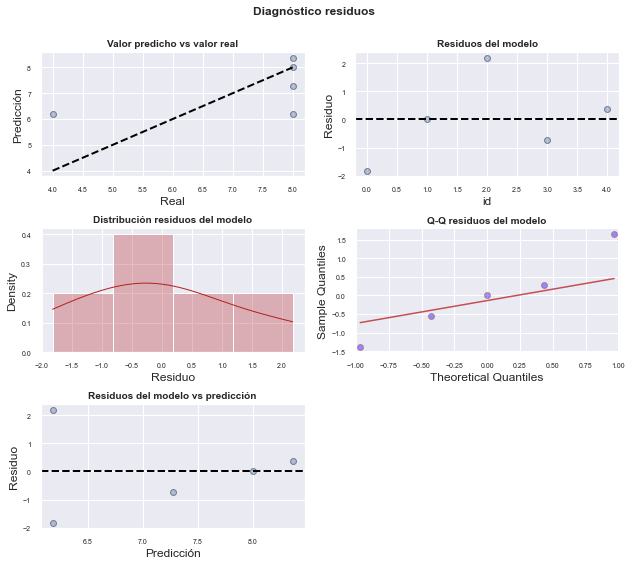


 Predicciones:
       mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
6  6.181818  1.149919       2.522262       9.841374     -0.364595   
0  8.000000  1.019294       4.756150      11.243850      1.676573   
4  6.181818  1.149919       2.522262       9.841374     -0.364595   
5  7.272727  0.765243       4.837384       9.708071      1.323436   

   obs_ci_upper  
6     12.728231  
0     14.323427  
4     12.728231  
5     13.222019  

El error (rmse) de test es: 11.386522408619042



**********************************************************************************************************************
**********************************************************************************************************************
Lugar: Filtrado 13 - Turno F13 - Lote 1315
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
Número de datos:  7
Variables X: ['ET', 'RS_PROM']



                            OLS Regression Results                       

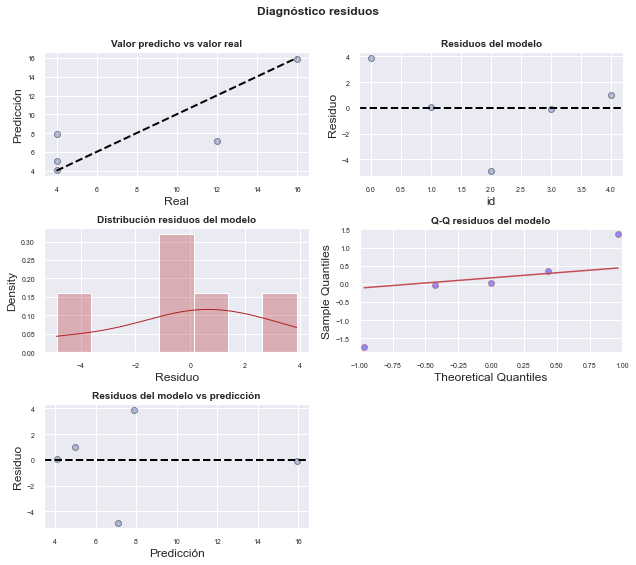


 Predicciones:
        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
6   7.877290  2.288116      -1.967680      17.722259    -13.707093   
0   4.067971  4.462735     -15.133627      23.269570    -23.091991   
4   7.120297  2.396957      -3.192978      17.433573    -14.681671   
5  15.931454  4.349124      -2.781317      34.644224    -10.885144   

   obs_ci_upper  
6     29.461672  
0     31.227934  
4     28.922265  
5     42.748052  

El error (rmse) de test es: 7.500160654189488



**********************************************************************************************************************
**********************************************************************************************************************
Lugar: Filtrado 13 - Turno F13 - Lote 1305
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
Número de datos:  7
Variables X: ['ET', 'T_MAX', 'RS_PROM', 'HM_PROM']



                            OLS Regression Result

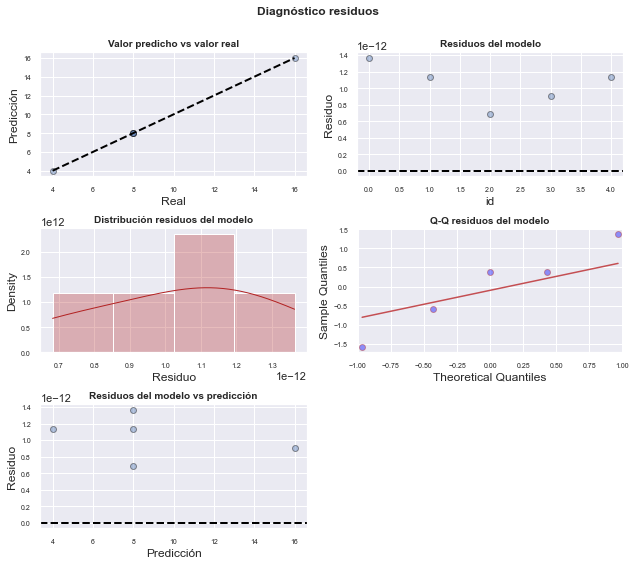


 Predicciones:
   mean  mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
6   8.0      NaN            NaN            NaN           NaN           NaN
0   4.0      NaN            NaN            NaN           NaN           NaN
4   8.0      NaN            NaN            NaN           NaN           NaN
5  16.0      NaN            NaN            NaN           NaN           NaN

El error (rmse) de test es: 133.19603675531545



**********************************************************************************************************************
**********************************************************************************************************************
Lugar: Filtrado 13 - Turno F13 - Lote 1320
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
Número de datos:  8
Variables X: ['HM_PROM']



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:           

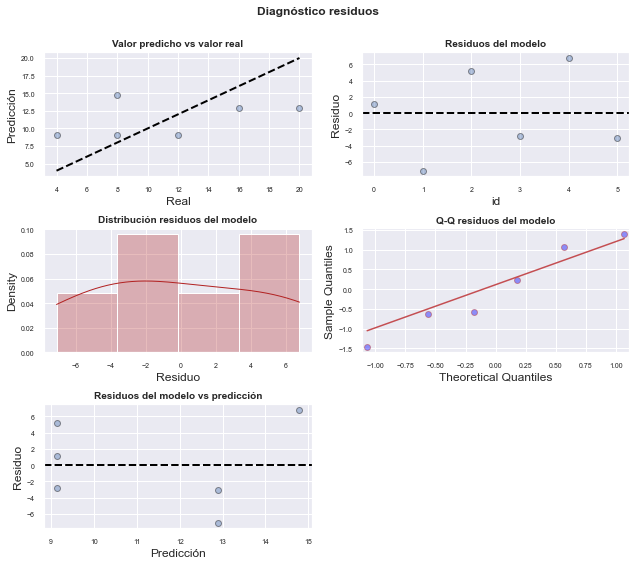


 Predicciones:
        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
6   9.132075  3.373087      -0.233115      18.497266     -9.871756   
0  12.905660  2.949679       4.716039      21.095282     -5.547218   
4   9.132075  3.373087      -0.233115      18.497266     -9.871756   
5   9.132075  3.373087      -0.233115      18.497266     -9.871756   

   obs_ci_upper  
6     28.135907  
0     31.358539  
4     28.135907  
5     28.135907  

El error (rmse) de test es: 7.779444576637098



**********************************************************************************************************************
**********************************************************************************************************************
Lugar: Filtrado 13 - Turno F13 - Lote 1316
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
Número de datos:  7
Variables X: ['T_MIN']



                            OLS Regression Results                           

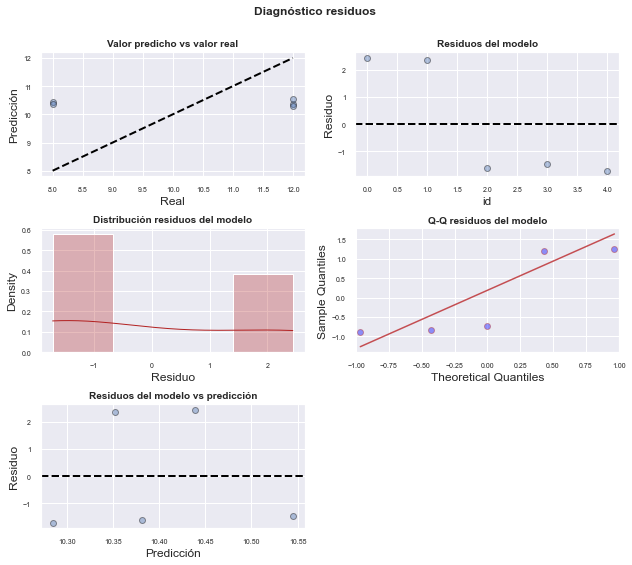


 Predicciones:
        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
6  10.438647  1.234613       6.509559      14.367736      1.487321   
0  10.351691  1.289620       6.247545      14.455836      1.322155   
4  10.380676  1.157210       6.697918      14.063435      1.534705   
5  10.544928  2.179147       3.609908      17.479947     -0.075006   

   obs_ci_upper  
6     19.389973  
0     19.381226  
4     19.226648  
5     21.164861  

El error (rmse) de test es: 7.221182352877002



**********************************************************************************************************************
**********************************************************************************************************************
Lugar: Filtrado 13 - Turno F13 - Lote 1310
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
Número de datos:  10
Variables X: ['T_MAX']



                            OLS Regression Results                          

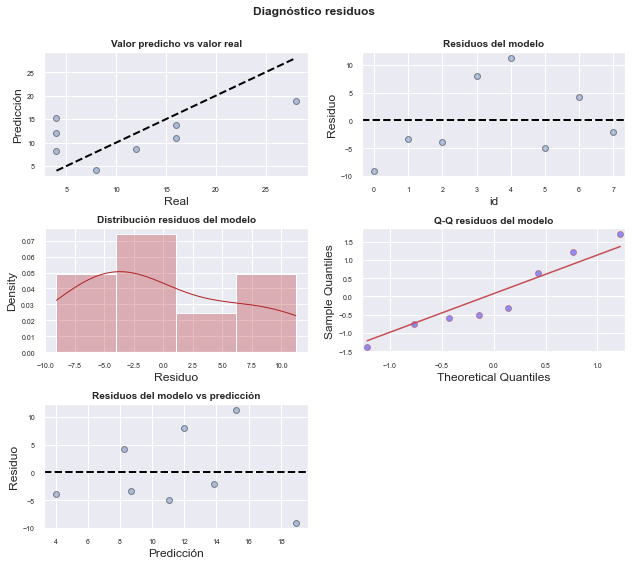


 Predicciones:
        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
9  18.941860  5.347554       5.856867      32.026854     -3.766150   
1   8.709302  3.193905       0.894097      16.524507    -11.428078   
0   4.058140  5.347554      -9.026854      17.143133    -18.649871   
8  11.965116  2.697129       5.365479      18.564754     -7.732393   

   obs_ci_upper  
9     41.649871  
1     28.846683  
0     26.766150  
8     31.662626  

El error (rmse) de test es: 5.189968795203563



**********************************************************************************************************************
**********************************************************************************************************************
Lugar: Filtrado 13 - Turno F13 - Lote 1308
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
Número de datos:  8
Variables X: ['HM_PROM']



                            OLS Regression Results                         

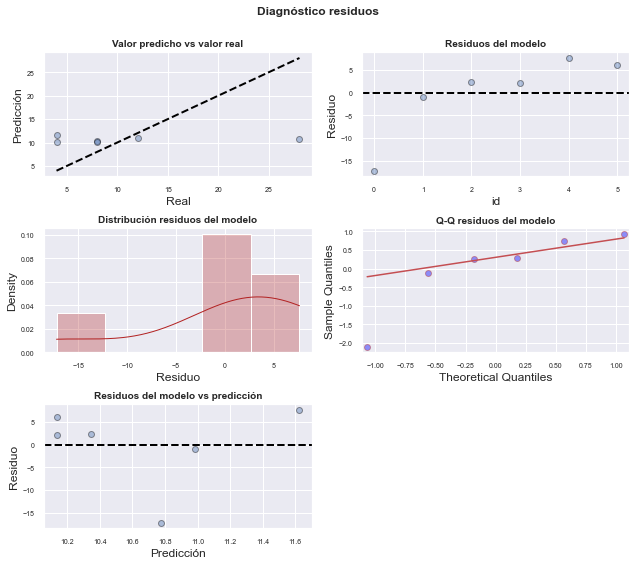


 Predicciones:
        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
6  10.773333  4.182163      -0.838213      22.384880    -19.437293   
0  10.986667  4.782487      -2.291645      24.264978    -19.902935   
4  10.346667  4.782487      -2.931645      23.624978    -20.542935   
5  10.133333  5.799617      -5.968984      26.235651    -22.071302   

   obs_ci_upper  
6     40.983959  
0     41.876268  
4     41.236268  
5     42.337969  

El error (rmse) de test es: 18.152342977025068



**********************************************************************************************************************
**********************************************************************************************************************
Lugar: Filtrado 13 - Turno F13 - Lote 1311
Plaga:  DAGBERTUS MINENSIS, DAGBERTUS PERUANUS
Caracteristica:  N° INFLORESC. INFESTADAS
Número de datos:  7
Variables X: ['TMP_PROM']



                            OLS Regression Results                       

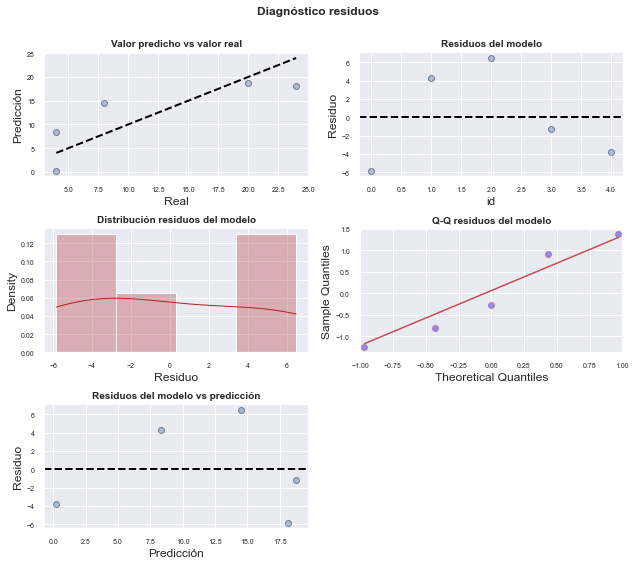


 Predicciones:
        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
6  18.162528  3.626740       6.620624      29.704433     -4.334806   
0   8.333180  3.068176      -1.431124      18.097484    -13.306047   
4  14.483093  2.881660       5.312365      23.653822     -6.894857   
5  18.772263  3.788866       6.714401      30.830126     -3.994084   

   obs_ci_upper  
6     40.659863  
0     29.972407  
4     35.861044  
5     41.538611  

El error (rmse) de test es: 3.731248846054178



**********************************************************************************************************************


In [22]:
arrPlagas = []
dfFilter = dfF30

for filtrado in arrFiltrados:
    dfFiltrado = dfFilter[dfFilter['Filtrado'] == filtrado]
    arrTurno = dfFiltrado['Turno'].unique()
    for turno in arrTurno:
        dfTurno = dfFiltrado[dfFiltrado['Turno'] == turno]
        arrLote = dfTurno['Lote'].unique()
        for lote in arrLote:  
            dfLote = dfTurno[dfTurno['Lote'] == lote]
            arrPlagaxLote = dfLote['Plaga'].unique()
            for plaga in arrPlagaxLote:
                dfPlaga = dfLote[dfLote['Plaga'] == plaga]
                arrPlagaxCarac = dfPlaga['Caracteristica'].unique()
                for caracteristica in arrPlagaxCarac:
                    dfCarac = dfPlaga[dfPlaga['Caracteristica'] == caracteristica]
                    dfCarac = dfCarac.sort_values(by=['Fecha'])
         
                    dfCarac = dfCarac.groupby(['Fecha','Fundo','Filtrado','Turno','Plaga','Caracteristica'])['Porcentaje'].sum().reset_index()
                    
                    fl_df_weather = df_weather[df_weather['Fecha'].isin(dfCarac['Fecha'])]
                    fl_df_weather = fl_df_weather.sort_values(by=['Fecha'])
                    fl_df_weather.reset_index(drop = True, inplace = True)
                    fl_df_weather = fl_df_weather.rename(columns = {'Fecha' : 'FechaClima'})
                    df_union = fl_df_weather.join(dfCarac)
                 
                    #df_union = df_union[['Fecha','ET','TMP_PROM','T_MIN','T_MAX','RS_PROM','HM_PROM','Grado']]        
                    df_union = df_union[['Fecha','ET','TMP_PROM','T_MIN','T_MAX','RS_PROM','HM_PROM','Porcentaje']]        
                                   
                    df_union[["Porcentaje"]] = df_union[["Porcentaje"]].apply(pd.to_numeric)
                
                    dfCorrelacion = df_union.corr().abs()
                    
                    dfCorrelacion_index = dfCorrelacion[dfCorrelacion['Porcentaje'] > 0.60]

                
                    
                    if dfCorrelacion_index.shape[0] > 1:   
                        
                        arrColumns = dfCorrelacion_index.columns
                        arrColumnsUnion = []
                        ###########################################
                        for column in arrColumns:
                            if (dfCorrelacion_index[column]['Porcentaje'] > 0.60) & (column != 'Porcentaje'):
                                    arrColumnsUnion.append(column)
                        ############################################  
                        
                         #Creando regresión lineal
                        df_union = df_union.drop('Fecha' ,axis=1)
                        df_union = df_union.fillna(df_union.mean())
                        
                      
                        if df_union[arrColumnsUnion].shape[0] > 6:   
                            print('**********************************************************************************************************************')
                            # División de los datos en train y test
                            # ==============================================================================
                            print('Lugar: Filtrado {} - Turno {} - Lote {}'.format(filtrado,turno, lote))
                            print('Plaga: ', plaga)
                            print('Caracteristica: ', caracteristica)
                            print('Número de datos: ',  df_union[arrColumnsUnion].shape[0])
                            print('Variables X:', arrColumnsUnion)
                            print("\n"*2)
                            
                            X = df_union[arrColumnsUnion]
                            y = df_union['Porcentaje']

                            X_train, X_test, y_train, y_test = train_test_split(
                                                                    X,
                                                                    y.values.reshape(-1,1),
                                                                    train_size   = 0.8,
                                                                    random_state = 1234,
                                                                    shuffle      = True
                                                                )
                            # Creación del modelo utilizando matrices como en scikitlearn
                            # ==============================================================================
                            # A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
                            X_train = sm.add_constant(X_train, prepend=True)
                            modelo = sm.OLS(endog=y_train, exog=X_train,)
                            modelo = modelo.fit()
                            print(modelo.summary())
                            
                            print('\n Coeficientes')
                            print(modelo.params)
                            
                            # Intervalos de confianza para los coeficientes del modelo
                            # ==============================================================================
                            intervalos_ci = modelo.conf_int(alpha=0.05)
                            intervalos_ci.columns = ['2.5%', '97.5%']
                            
                            print('\nIntervalos de confianza: ')
                            print(intervalos_ci)
                            
                            
                            print('\n Diagnostico de residuos:')
                            # Diagnóstico errores (residuos) de las predicciones de entrenamiento
                            # ==============================================================================
                            y_train = y_train.flatten()
                            prediccion_train = modelo.predict(exog = X_train)
                            residuos_train   = prediccion_train - y_train
                            
                            # Gráficos
                            # ==============================================================================
                            fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

                            axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                                            'k--', color = 'black', lw=2)
                            axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
                            axes[0, 0].set_xlabel('Real')
                            axes[0, 0].set_ylabel('Predicción')
                            axes[0, 0].tick_params(labelsize = 7)

                            axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                                               edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
                            axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
                            axes[0, 1].set_xlabel('id')
                            axes[0, 1].set_ylabel('Residuo')
                            axes[0, 1].tick_params(labelsize = 7)

                            sns.histplot(
                                data    = residuos_train,
                                stat    = "density",
                                kde     = True,
                                line_kws= {'linewidth': 1},
                                color   = "firebrick",
                                alpha   = 0.3,
                                ax      = axes[1, 0]
                            )

                            axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                                                 fontweight = "bold")
                            axes[1, 0].set_xlabel("Residuo")
                            axes[1, 0].tick_params(labelsize = 7)


                            sm.qqplot(
                                residuos_train,
                                fit   = True,
                                line  = 'q',
                                ax    = axes[1, 1], 
                                color = 'firebrick',
                                alpha = 0.4,
                                lw    = 2
                            )
                            axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
                            axes[1, 1].tick_params(labelsize = 7)

                            axes[2, 0].scatter(prediccion_train, residuos_train,
                                               edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
                            axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
                            axes[2, 0].set_xlabel('Predicción')
                            axes[2, 0].set_ylabel('Residuo')
                            axes[2, 0].tick_params(labelsize = 7)

                            # Se eliminan los axes vacíos
                            fig.delaxes(axes[2,1])

                            fig.tight_layout()
                            plt.subplots_adjust(top=0.9)
                            fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");
                            plt.show()
                            
                            # Predicciones con intervalo de confianza 
                            # ==============================================================================
                            predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
                            print('\n Predicciones:')
                            print(predicciones.head(4))
                            
                            # Error de test del modelo 
                            # ==============================================================================
                            X_test = sm.add_constant(X_test, prepend=True)
                            predicciones = modelo.predict(exog = X_test)
                            rmse = mean_squared_error(
                                    y_true  = y_test,
                                    y_pred  = predicciones,
                                    squared = False
                                   )
                            print("")
                            print(f"El error (rmse) de test es: {rmse}")
                            
                            print("\n"*2)
                            print('**********************************************************************************************************************')
                            